<a href="https://colab.research.google.com/github/jingvf/IDS/blob/main/Pytorch_AttentionGRU_DP_experiment%20epoch20%20epsilon5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opacus==1.1.3 -q # 指定稳定版本

import opacus
print(opacus.__version__)

1.1.3


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader
from opacus import PrivacyEngine
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# 加载数据
data_path = '/content/drive/MyDrive/2025paper/dataset/small_dataset.csv'  # 替换为你的数据路径
df = pd.read_csv(data_path)

Using device: cuda


In [3]:
# 输出类别数量
num_classes = df['Class'].nunique()
print(f"总类别数: {num_classes}")

# 输出每个类别的数量
class_counts = df['Class'].value_counts()
print("每个类别的样本数量：")
print(class_counts)
print(df.head())

总类别数: 5
每个类别的样本数量：
Class
Normal          946844
SpoofingRPM      65490
SpoofingGear     59725
DoS              10553
Fuzzy             8967
Name: count, dtype: int64
      Timestamp CAN ID  DLC Data[0] Data[1] Data[2] Data[3] Data[4] Data[5]  \
0  1.478192e+09    316    8      45      29      24      ff      29      24   
1  1.478192e+09    316    8      45      29      24      ff      29      24   
2  1.478195e+09   0140    8      00      00      00      00      08      28   
3  1.478191e+09   0545    8      d8      00      00      8a      00      00   
4  1.478195e+09   043f    8       1      45      60      ff      6b       0   

  Data[6] Data[7]         Class  
0       0      ff   SpoofingRPM  
1       0      ff   SpoofingRPM  
2      2f      15        Normal  
3      00      00        Normal  
4       0       0  SpoofingGear  


In [4]:
# 1. CAN ID 转成 int（十六进制字符串 → 十进制）
# =====================
df["CAN ID"] = df["CAN ID"].apply(lambda x: int(str(x), 16) if isinstance(x, str) else int(x))

# 特征列
feature_cols = ["CAN ID", "DLC"] + [f"Data[{i}]" for i in range(8)]
X_features = df[feature_cols].astype(str).applymap(lambda x: int(x, 16) if isinstance(x, str) else int(x)).values

# 标签
y = df["Class"].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# 数据维度调整 (B, T, F)，这里把 T=1 表示每条 CAN 消息为一个时间步
X_scaled = X_scaled[:, np.newaxis, :]  # shape -> [num_samples, 1, num_features]

# =====================
# 5. 类别权重 (用统计的数量，如果需要自动算就用 np.bincount(y_encoded))
# =====================
counts = [946844, 65490, 59725, 10553, 8967]  # 示例：之前统计好的数量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


/tmp/ipython-input-507287565.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_features = df[feature_cols].astype(str).applymap(lambda x: int(x, 16) if isinstance(x, str) else int(x)).values


Using device: cuda


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 转 Tensor
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
# 3. 模型定义：CNN-Attention (DP友好)
# ================================
class DPMultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, T, C = x.shape
        Q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        attn_scores = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_out = attn_weights @ V
        attn_out = attn_out.transpose(1, 2).contiguous().view(B, T, C)
        return self.out_proj(attn_out)

class DPCNNAttention(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, hidden_dim=128):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=8, num_channels=hidden_dim)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=hidden_dim)
        self.attn = DPMultiHeadSelfAttention(hidden_dim, num_heads)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.relu(self.gn1(self.conv1(x)))
        x = F.relu(self.gn2(self.conv2(x)))
        x = x.transpose(1, 2)
        attn_out = self.attn(x)
        pooled = attn_out.mean(dim=1)
        return self.fc(pooled)

In [7]:
model = DPCNNAttention(11, num_classes).to(device)

from torchsummary import summary
summary(model, input_size=(100, 11))  # 序列长度为10

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 100]           4,352
         GroupNorm-2             [-1, 128, 100]             256
            Conv1d-3             [-1, 128, 100]          49,280
         GroupNorm-4             [-1, 128, 100]             256
            Linear-5             [-1, 100, 128]          16,512
            Linear-6             [-1, 100, 128]          16,512
            Linear-7             [-1, 100, 128]          16,512
            Linear-8             [-1, 100, 128]          16,512
DPMultiHeadSelfAttention-9             [-1, 100, 128]               0
           Linear-10                    [-1, 5]             645
Total params: 120,837
Trainable params: 120,837
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.88
Params size (MB): 0.46
Estim

In [8]:
# 4. 训练函数 (支持 DP-SGD & DP-Adam)
# ================================
def train_and_evaluate(train_loader, val_loader, test_loader, optimizer_type="SGD",
                       input_dim=11, num_classes=5, epochs=20, lr=1e-3,
                       max_grad_norm=1.0, target_epsilon=5.0, target_delta=1e-5):

    model = DPCNNAttention(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("Unknown optimizer type")

    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=epochs,
        target_epsilon=target_epsilon,
        target_delta=target_delta,
        max_grad_norm=max_grad_norm,
    )

    train_losses, val_accs, epsilons = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0
        progress_bar = tqdm(train_loader, desc=f"[{optimizer_type}] Epoch {epoch+1}/{epochs}", leave=False)

        for feats, labels in progress_bar:
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            total_loss += loss.item() * labels.size(0)
            total_correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = total_loss / len(train_loader.dataset)
        train_acc = total_correct / len(train_loader.dataset)
        train_losses.append(train_loss)

        # 验证
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for feats, labels in val_loader:
                feats, labels = feats.to(device), labels.to(device)
                outputs = model(feats)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total
        val_accs.append(val_acc)

        epsilon = privacy_engine.accountant.get_epsilon(delta=target_delta)
        epsilons.append(epsilon)
        print(f"[{optimizer_type}] Epoch {epoch+1}: Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, ε={epsilon:.2f}")

    # 测试
    model.eval()
    test_correct, test_total = 0, 0
    y_true_all, y_pred_all = [], []
    with torch.no_grad():
        for feats, labels in test_loader:
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            preds = outputs.argmax(1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            y_true_all.extend(labels.cpu().numpy())
            y_pred_all.extend(preds.cpu().numpy())

    test_acc = test_correct / test_total
    test_f1 = f1_score(y_true_all, y_pred_all, average="macro")
    conf_mat = confusion_matrix(y_true_all, y_pred_all)
    print(f"[{optimizer_type}] Final Test Accuracy={test_acc:.4f}, F1-score={test_f1:.4f}, ε={epsilons[-1]:.2f}")

    return train_losses, val_accs, epsilons, test_acc, test_f1, conf_mat

In [9]:

# ================================
# 5. 实验对比入口
# ================================
def run_experiments(train_loader, val_loader, test_loader, input_dim, num_classes):
    results = {}
    for opt in ["SGD", "Adam"]:
        print(f"\n==== Running with DP-{opt} ====")
        train_losses, val_accs, epsilons, test_acc, test_f1, conf_mat = train_and_evaluate(
            train_loader, val_loader, test_loader,
            optimizer_type=opt,
            input_dim=input_dim,
            num_classes=num_classes
        )
        results[opt] = {"train_losses": train_losses,
                        "val_accs": val_accs,
                        "epsilons": epsilons,
                        "test_acc": test_acc,
                        "test_f1": test_f1,
                        "conf_mat": conf_mat}

    # 可视化
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(results["SGD"]["train_losses"], label="DP-SGD")
    plt.plot(results["Adam"]["train_losses"], label="DP-Adam")
    plt.title("Training Loss"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(results["SGD"]["val_accs"], label="DP-SGD")
    plt.plot(results["Adam"]["val_accs"], label="DP-Adam")
    plt.title("Validation Accuracy"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(results["SGD"]["epsilons"], label="DP-SGD")
    plt.plot(results["Adam"]["epsilons"], label="DP-Adam")
    plt.title("Epsilon over Epochs"); plt.legend()
    plt.show()

    return results


==== Running with DP-SGD ====


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:133: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
[SGD] Epoch 1/20:   0%|          | 0/2984 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_

[SGD] Epoch 1: Loss=0.2924, Train Acc=0.9376, Val Acc=0.9771, ε=3.39


[SGD] Epoch 2: Loss=0.1344, Train Acc=0.9822, Val Acc=0.9815, ε=3.60


[SGD] Epoch 3: Loss=0.1112, Train Acc=0.9817, Val Acc=0.9815, ε=3.74


[SGD] Epoch 4: Loss=0.0979, Train Acc=0.9802, Val Acc=0.9815, ε=3.86


[SGD] Epoch 5: Loss=0.0854, Train Acc=0.9825, Val Acc=0.9815, ε=3.96


[SGD] Epoch 6: Loss=0.0744, Train Acc=0.9803, Val Acc=0.9815, ε=4.06


[SGD] Epoch 7: Loss=0.0563, Train Acc=0.9820, Val Acc=0.9816, ε=4.15


[SGD] Epoch 8: Loss=0.0448, Train Acc=0.9878, Val Acc=0.9925, ε=4.23


[SGD] Epoch 9: Loss=0.0361, Train Acc=0.9927, Val Acc=0.9933, ε=4.30


[SGD] Epoch 10: Loss=0.0296, Train Acc=0.9939, Val Acc=0.9941, ε=4.38


[SGD] Epoch 11: Loss=0.0258, Train Acc=0.9948, Val Acc=0.9950, ε=4.46


[SGD] Epoch 12: Loss=0.0232, Train Acc=0.9969, Val Acc=0.9955, ε=4.52


[SGD] Epoch 13: Loss=0.0212, Train Acc=0.9952, Val Acc=0.9960, ε=4.58


[SGD] Epoch 14: Loss=0.0191, Train Acc=0.9947, Val Acc=0.9961, ε=4.64


[SGD] Epoch 15: Loss=0.0174, Train Acc=0.9967, Val Acc=0.9964, ε=4.71


[SGD] Epoch 16: Loss=0.0168, Train Acc=0.9972, Val Acc=0.9965, ε=4.77


[SGD] Epoch 17: Loss=0.0159, Train Acc=0.9947, Val Acc=0.9966, ε=4.83


[SGD] Epoch 18: Loss=0.0161, Train Acc=0.9954, Val Acc=0.9967, ε=4.89


[SGD] Epoch 19: Loss=0.0155, Train Acc=0.9974, Val Acc=0.9968, ε=4.94


[SGD] Epoch 20: Loss=0.0159, Train Acc=0.9985, Val Acc=0.9969, ε=5.00
[SGD] Final Test Accuracy=0.9968, F1-score=0.9674, ε=5.00

==== Running with DP-Adam ====


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:133: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
[Adam] Epoch 1/20:   0%|          | 0/2984 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad

[Adam] Epoch 1: Loss=0.0519, Train Acc=0.9912, Val Acc=0.9975, ε=3.39


[Adam] Epoch 2: Loss=0.0149, Train Acc=0.9956, Val Acc=0.9972, ε=3.60


[Adam] Epoch 3: Loss=0.0118, Train Acc=0.9972, Val Acc=0.9977, ε=3.74


[Adam] Epoch 4: Loss=0.0115, Train Acc=0.9978, Val Acc=0.9984, ε=3.86


[Adam] Epoch 5: Loss=0.0105, Train Acc=0.9985, Val Acc=0.9983, ε=3.96


[Adam] Epoch 6: Loss=0.0115, Train Acc=0.9966, Val Acc=0.9984, ε=4.06


[Adam] Epoch 7: Loss=0.0108, Train Acc=1.0012, Val Acc=0.9985, ε=4.15


[Adam] Epoch 8: Loss=0.0110, Train Acc=0.9981, Val Acc=0.9979, ε=4.23


[Adam] Epoch 9: Loss=0.0106, Train Acc=0.9979, Val Acc=0.9984, ε=4.30


[Adam] Epoch 10: Loss=0.0125, Train Acc=0.9971, Val Acc=0.9981, ε=4.38


[Adam] Epoch 11: Loss=0.0126, Train Acc=0.9954, Val Acc=0.9981, ε=4.46


[Adam] Epoch 12: Loss=0.0119, Train Acc=1.0001, Val Acc=0.9984, ε=4.52


[Adam] Epoch 13: Loss=0.0118, Train Acc=0.9983, Val Acc=0.9984, ε=4.58


[Adam] Epoch 14: Loss=0.0100, Train Acc=1.0001, Val Acc=0.9990, ε=4.64


[Adam] Epoch 15: Loss=0.0081, Train Acc=0.9984, Val Acc=0.9989, ε=4.71


[Adam] Epoch 16: Loss=0.0096, Train Acc=0.9989, Val Acc=0.9987, ε=4.77


[Adam] Epoch 17: Loss=0.0117, Train Acc=0.9984, Val Acc=0.9986, ε=4.83


[Adam] Epoch 18: Loss=0.0115, Train Acc=0.9987, Val Acc=0.9988, ε=4.89


[Adam] Epoch 19: Loss=0.0145, Train Acc=0.9993, Val Acc=0.9986, ε=4.94


[Adam] Epoch 20: Loss=0.0123, Train Acc=0.9994, Val Acc=0.9985, ε=5.00
[Adam] Final Test Accuracy=0.9985, F1-score=0.9886, ε=5.00


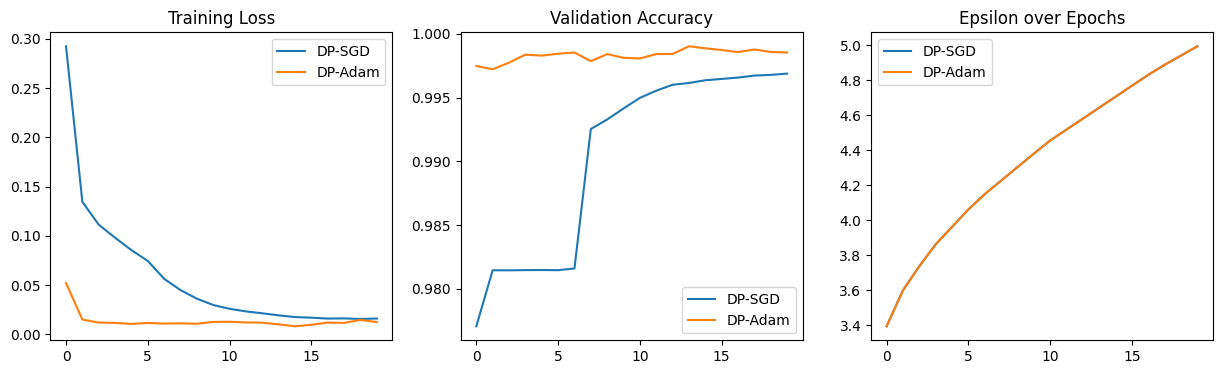

DP-SGD Confusion Matrix:
 [[  1573      0      0      0      0]
 [     0   1095    255      0      0]
 [    81     70 141784    125      0]
 [     0      0      0   8889      0]
 [     0      0      0      0   9865]]
DP-Adam Confusion Matrix:
 [[  1573      0      0      0      0]
 [     0   1251     99      0      0]
 [    23     11 141909    117      0]
 [     0      0      0   8889      0]
 [     0      0      0      0   9865]]


In [10]:
# ================================
# 6. 运行实验
# ================================
results = run_experiments(train_loader, val_loader, test_loader,
                          input_dim=X_scaled.shape[2], num_classes=len(set(y_encoded)))

# 查看混淆矩阵
print("DP-SGD Confusion Matrix:\n", results["SGD"]["conf_mat"])
print("DP-Adam Confusion Matrix:\n", results["Adam"]["conf_mat"])